# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [446]:
import json
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy
import torch
from PIL import Image

sns.set_theme()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from subpair import extract, pairwise_cosine

# Setup

In [4]:
img_folder = Path("../higherANML/experiments/data/ImageNet84")
feats_folder = Path("/users/l/f/lfrati/scratch/OmnImage_data/torchvision.models.vgg_ce631fc9ca0278a2")
cls2label = {}
with open(img_folder / "imagenet_class_index.json") as f:
    class_idx = json.load(f)
    cls2label = dict(class_idx.values())
    label2cls = {v: k for k, v in cls2label.items()}

In [5]:
all_feature_files = sorted(feats_folder.iterdir())
cls2file = {f.stem: f for f in all_feature_files}
imgcls_file = all_feature_files[0]
imgcls = imgcls_file.stem
print(f"Working with class: {imgcls} ({cls2label[imgcls]})")

Working with class: n01440764 (tench)


In [6]:
X = np.load(imgcls_file)

In [7]:
distances = pairwise_cosine(X)

In [8]:
num_samples = 20
best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'space' of function 'step'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/subpair/minimize.py", line 74:
@njit(parallel=True)
def step(pop, fitnesses, P, S, K, M, O, space):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for 

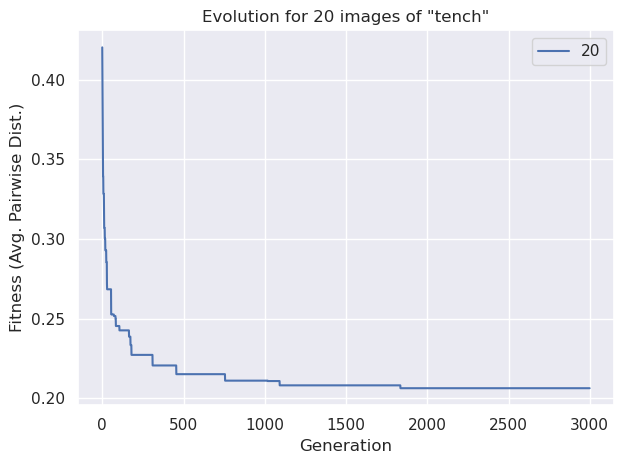

In [9]:
def plot_evolution(stats, num_samples=None, clsname=None):
    label = None
    if num_samples is not None:
        label = str(num_samples)
    normed_fits = np.array(stats["fits"]) / ((num_samples*(num_samples-1))/2)

    plt.plot(normed_fits, label=label)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Avg. Pairwise Dist.)")
    title = "Evolution"

    if num_samples is not None:
        title += f" for {num_samples} images"
    if clsname:
        title += f' of "{clsname}"'
    elif num_samples is not None:
        title += " per class"
    plt.title(title)
    plt.legend()
    plt.tight_layout()

plot_evolution(stats, num_samples, cls2label[imgcls])

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


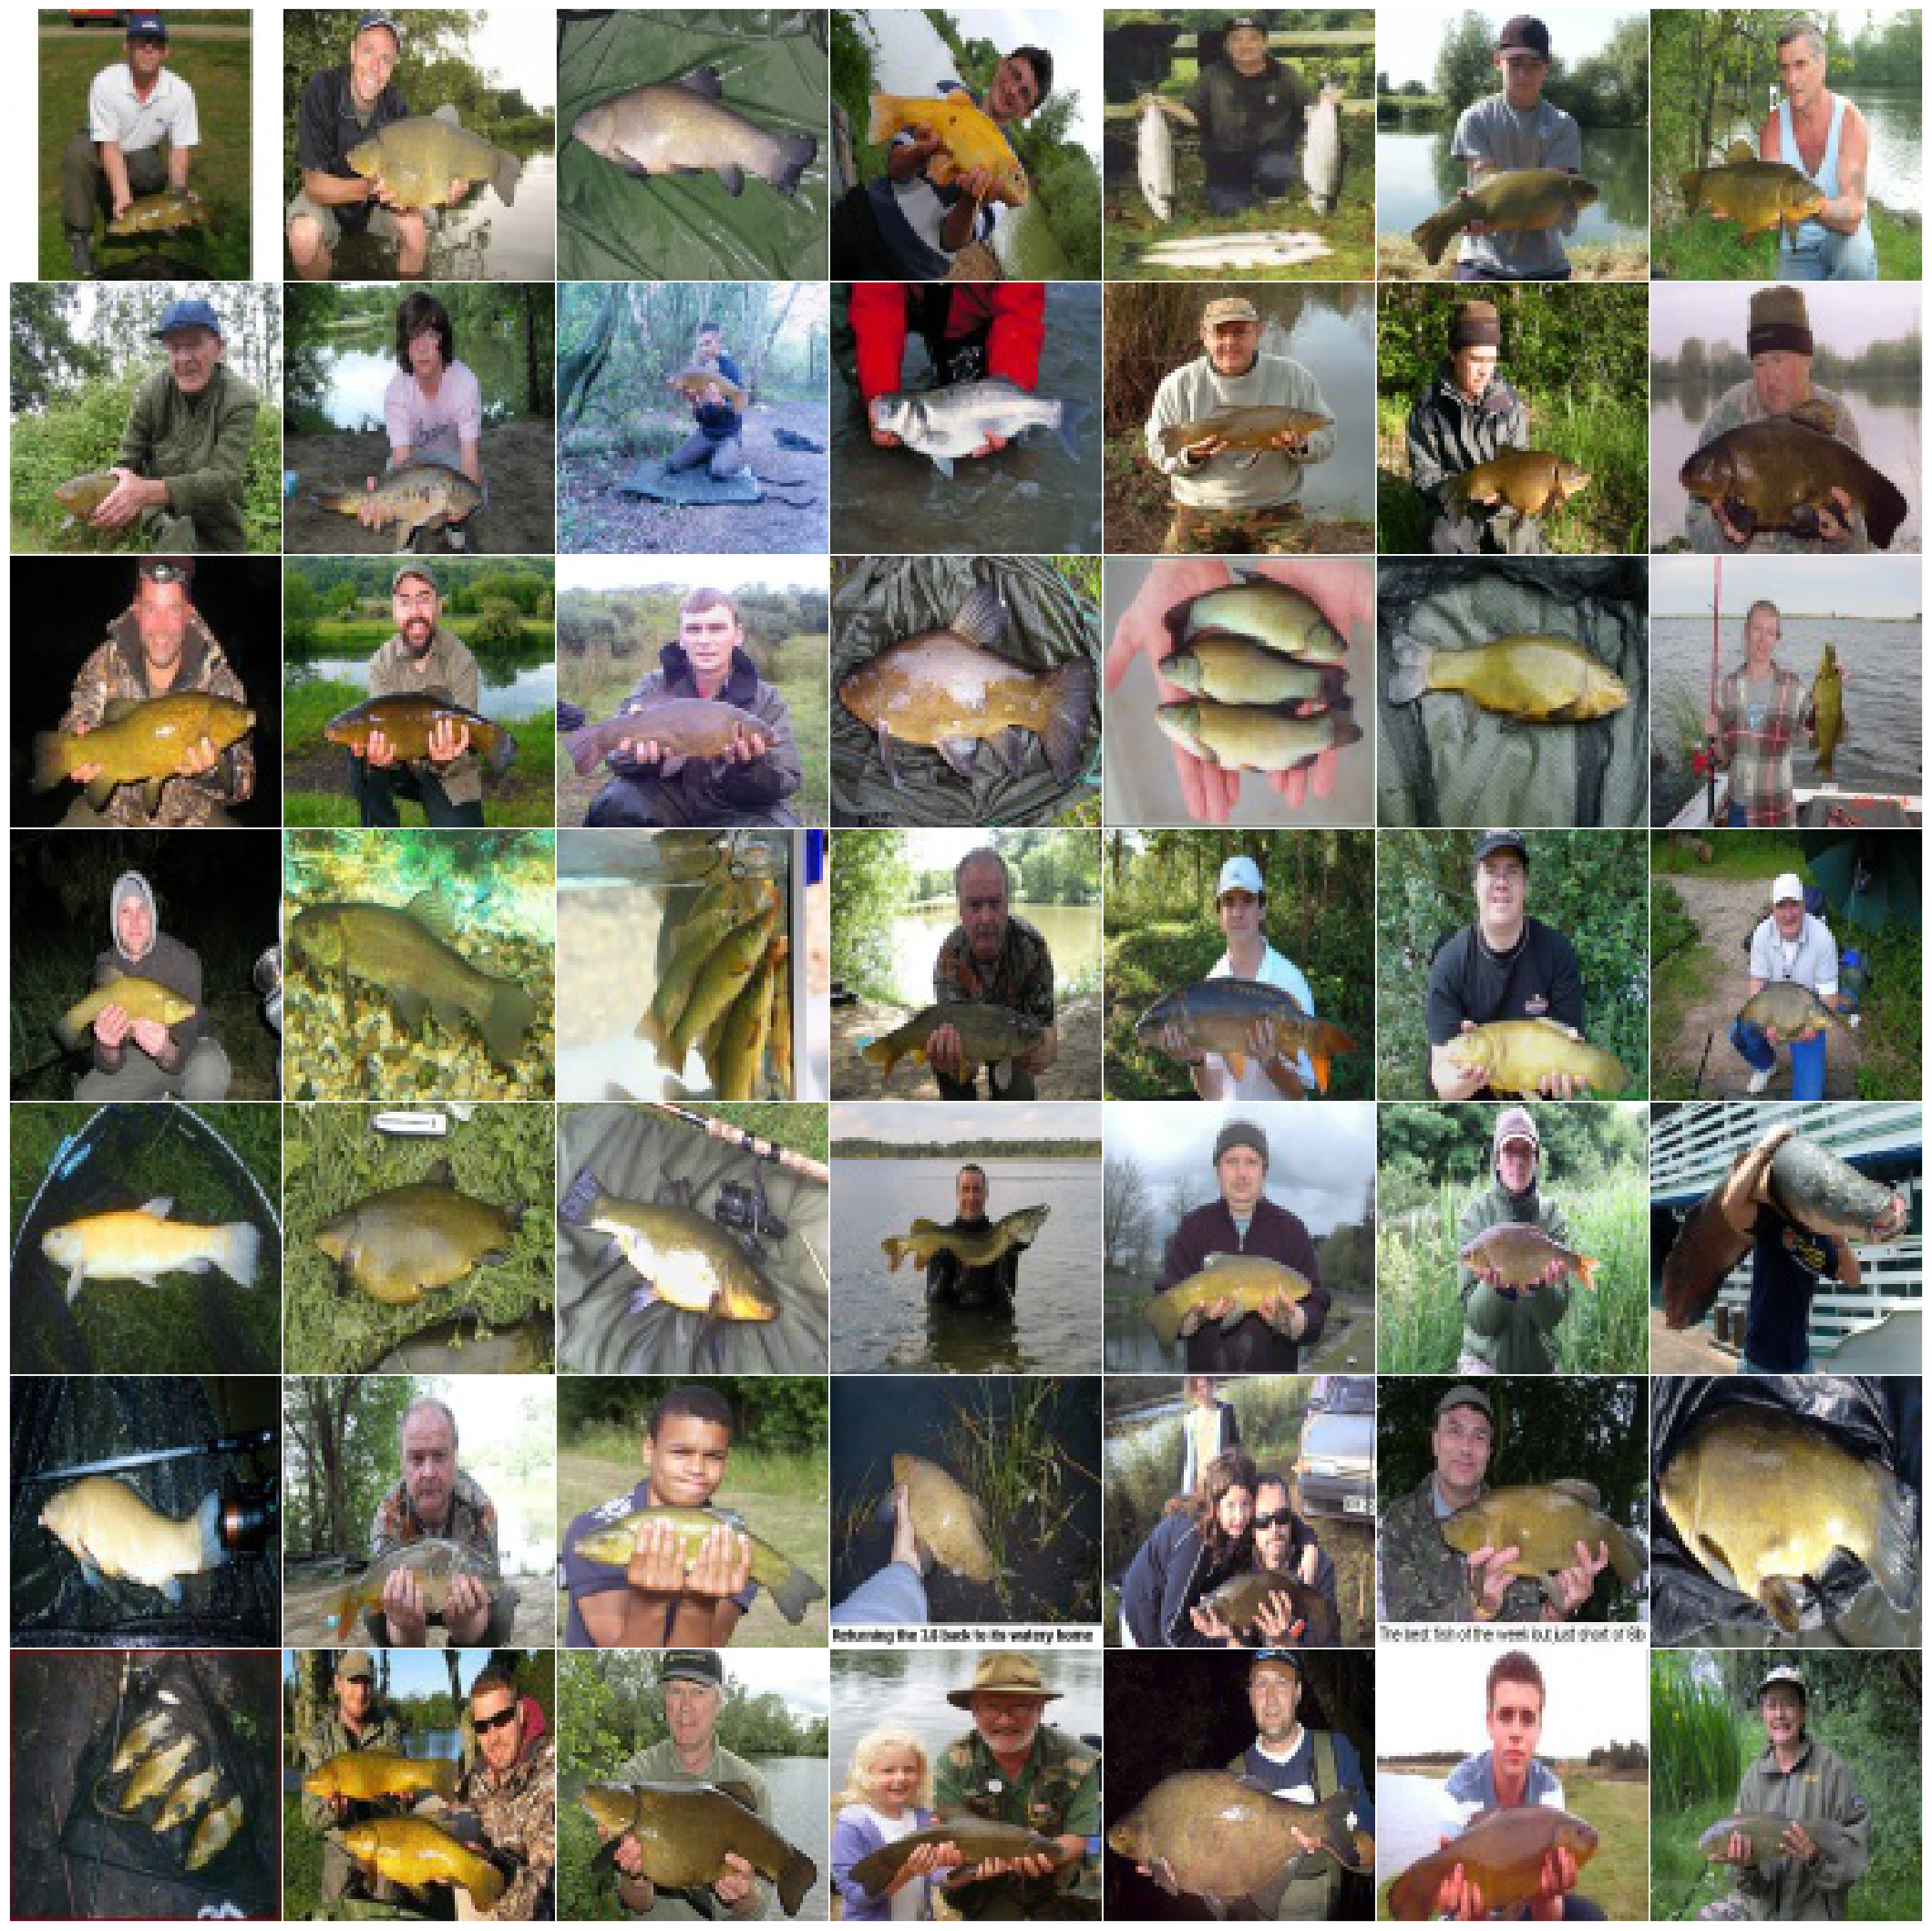

In [292]:
def get_image_paths(clsid):
    cls_folder = img_folder / clsid
    return sorted(cls_folder.iterdir())


def view_images(clsid, img_indices, img_paths=None, pack=False, size_multiple=3):
    if not img_paths:
        img_paths = get_image_paths(clsid)
    # indices are expected to correspond to the sorted filename ordering.
    selected_paths = [img_paths[i] for i in img_indices]
    nrows = int(np.sqrt(len(selected_paths)))
    ncols = int(np.ceil(len(selected_paths) / nrows))
    gkw = {}
    if pack:
        gkw["wspace"] = 0.0
        gkw["hspace"] = 0.0
        gkw["left"] = 0.0
        gkw["right"] = 1.0
        gkw["bottom"] = 0.0
        gkw["top"] = 1.0
    fig, axs = plt.subplots(nrows, ncols, squeeze=False, gridspec_kw=gkw,
                            figsize=(ncols*size_multiple, nrows*size_multiple))
    fig.set_tight_layout(True)
    if not pack:
        fig.suptitle(cls2label[clsid], fontsize=32)
    for i, f in enumerate(selected_paths):
        ax = axs[i // ncols, i % ncols]
        ax.imshow(Image.open(f), cmap='gray')
    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r, c]
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


view_images(imgcls, np.arange(49), pack=True)

# Single Class Analysis

In [12]:
imgcls_file = np.random.choice(all_feature_files)
imgcls = imgcls_file.stem
print(f"Computing image distances for class: {imgcls} ({cls2label[imgcls]})")
X = np.load(imgcls_file)
distances = pairwise_cosine(X)

Computing image distances for class: n02094114 (Norfolk_terrier)


In [13]:
sample_sizes = [10, 20, 50, 100, 200]
results = []
for i, num_samples in enumerate(sample_sizes):
    best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
    results.append({"num_samples": num_samples, "best": best, "stats": stats})

100%|██████████| 3000/3000 [00:34<00:00, 87.47it/s]


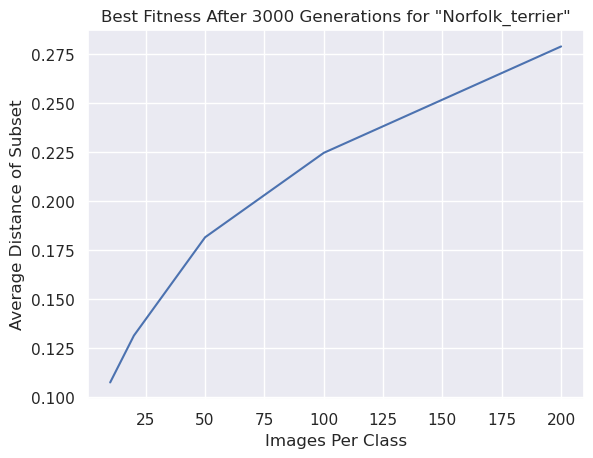

In [14]:
final_fitnesses = [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, results)]
plt.plot(sample_sizes, final_fitnesses)
plt.xlabel("Images Per Class")
plt.ylabel("Average Distance of Subset")
_ = plt.title(f'Best Fitness After 3000 Generations for "{cls2label[imgcls]}"')

# Aggregating Multiple Classes

In [101]:
import itertools


def plot_all_evolutions(evo_runs, clsname=None):
    for run in evo_runs:
        plot_evolution(run["stats"], run["num_samples"], clsname)


def compute_evolved_subsets(distances, sample_sizes=None, clsname=None, plot=False, **kwargs):
    if not sample_sizes:
        sample_sizes = [10, 20, 50, 100, 200]
    ext_args = dict(P=200, K=50, M=3, O=2, its=3000)
    if kwargs is not None:
        ext_args.update(kwargs)
        
    results = []
    for i, num_samples in enumerate(sample_sizes):
        best, stats = extract(distances, S=num_samples, **ext_args)
        results.append({"num_samples": num_samples, "best": best, "stats": stats})
        if plot:
            plot_evolution(stats, num_samples, clsname)
    return results


def compute_evolved_subsets_for_class(imgcls_file, sample_sizes=None, plot=False, **kwargs):
    imgcls = imgcls_file.stem
    X = np.load(imgcls_file)
    distances = pairwise_cosine(X)
    return compute_evolved_subsets(distances, sample_sizes, cls2label[imgcls], plot, **kwargs)


def get_fitnesses_for_classes(num_classes=None):
    if num_classes is None:
        cls_files = all_feature_files
    else:
        cls_files = np.random.choice(all_feature_files, size=num_classes, replace=False)
    total = len(cls_files)

    sample_sizes = [10, 20, 50, 100, 200]
    records = []
    for i, f in enumerate(cls_files):
        clsid = f.stem
        clsname = cls2label[clsid]
        print(f"Computing evolved subsets for class {i}/{total}: {clsid} ({clsname})")
        all_stats = compute_evolved_subsets_for_class(f, sample_sizes)
        dists = [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, all_stats)]
        records.extend(zip(itertools.repeat(clsid), itertools.repeat(clsname), sample_sizes, dists))
    
    return pd.DataFrame.from_records(records, columns=("Class ID", "Label", "Subset Size", "Avg. Dist."))

100%|██████████| 3000/3000 [00:33<00:00, 90.11it/s]


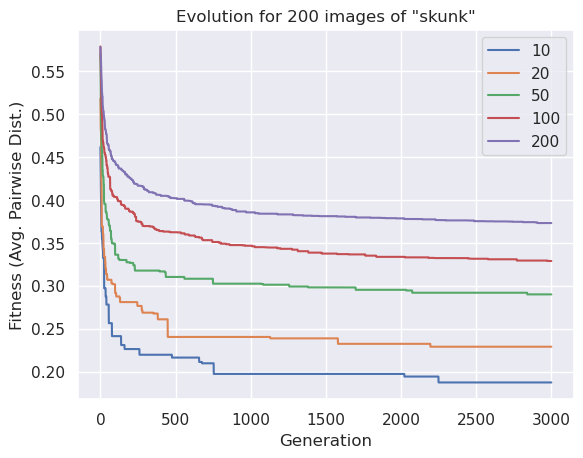

In [29]:
clsname = "skunk"#np.random.choice(list(label2cls.keys()))
clsfile = cls2file[label2cls[clsname]]
res = compute_evolved_subsets_for_class(clsfile, plot=True)

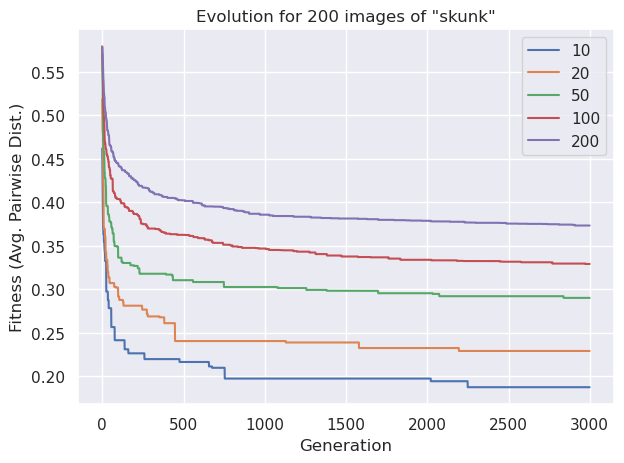

In [32]:
import pickle
with open(Path(f"{clsname}-evolution-runs.pkl"), "wb") as f:
    pickle.dump(res, f)

plot_all_evolutions(res, clsname)
_ = plt.savefig(f"{clsname}-evolution.pdf")

# All Classes Up to N=200

In [18]:
#df = get_fitnesses_for_classes()
df = pd.read_pickle("evolved_subset_fitnesses.pkl")

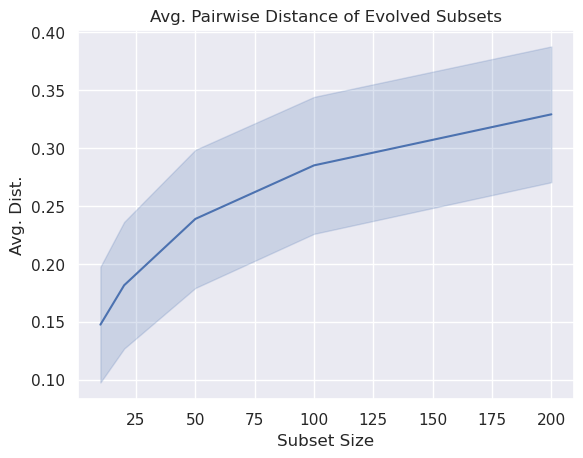

In [44]:
ax = sns.lineplot(data=df, x="Subset Size", y="Avg. Dist.", errorbar="sd")#, hue="Label", legend=False)
_ = ax.set_title("Avg. Pairwise Distance of Evolved Subsets")

In [22]:
df#.to_pickle("evolved_subset_fitnesses.pkl")

Class ID          Label  Subset Size  Avg. Dist.
0     n01440764          tench           10    0.180353
1     n01440764          tench           20    0.209126
2     n01440764          tench           50    0.240166
3     n01440764          tench          100    0.270542
4     n01440764          tench          200    0.299189
...         ...            ...          ...         ...
4995  n15075141  toilet_tissue           10    0.204570
4996  n15075141  toilet_tissue           20    0.196619
4997  n15075141  toilet_tissue           50    0.278168
4998  n15075141  toilet_tissue          100    0.336320
4999  n15075141  toilet_tissue          200    0.373999

[5000 rows x 4 columns]

# Study of Non-Monotonic Curves

['Afghan_hound' 'African_grey' 'Bernese_mountain_dog' 'French_horn'
 'Italian_greyhound' 'Kerry_blue_terrier' 'bathing_cap' 'binoculars'
 'burrito' 'chain' 'corn' 'crane' 'gazelle' 'giant_panda' 'maillot'
 'malinois' 'medicine_chest' 'mobile_home' 'puck' 'racer' 'revolver'
 'spatula' 'television' 'toilet_tissue' 'umbrella' 'warthog' 'wild_boar']
['n02088094' 'n01817953' 'n02107683' 'n03394916' 'n02091032' 'n02093859'
 'n02807133' 'n02841315' 'n07880968' 'n02999410' 'n12144580' 'n02012849'
 'n03126707' 'n02423022' 'n02510455' 'n03710637' 'n03710721' 'n02105162'
 'n03742115' 'n03776460' 'n04019541' 'n04037443' 'n04086273' 'n04270147'
 'n04404412' 'n15075141' 'n04507155' 'n02397096' 'n02396427']


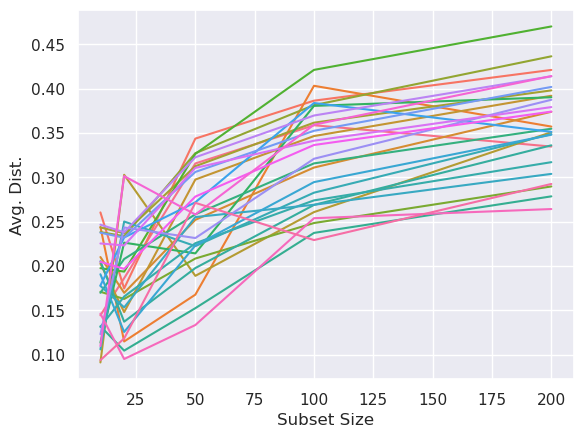

In [20]:
def get_decreasing(group):
    dists = group["Avg. Dist."]
    has_decrease = np.any([n1 > n2 for n1, n2 in zip(dists, dists.iloc[1:])])
    if has_decrease:
        return group
    else:
        return pd.DataFrame()

non_monotonics = df.groupby("Label").apply(get_decreasing)
print(non_monotonics["Label"].unique())
print(non_monotonics["Class ID"].unique())
ax = sns.lineplot(data=non_monotonics, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)

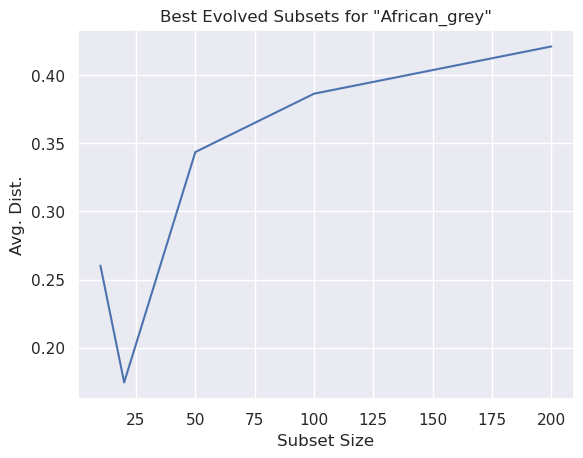

In [41]:
# Plot a single class.
clsname = "African_grey"
oneclass = df.loc[df["Label"] == clsname]
ax = sns.lineplot(data=oneclass, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)
_ = ax.set_title(f'Best Evolved Subsets for "{clsname}"')

100%|██████████| 3000/3000 [00:35<00:00, 85.13it/s]


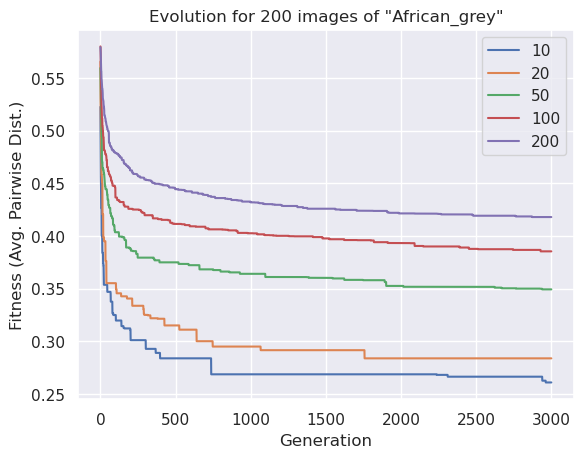

In [45]:
clsfile = cls2file[label2cls[clsname]]
res = compute_evolved_subsets_for_class(clsfile, plot=True)

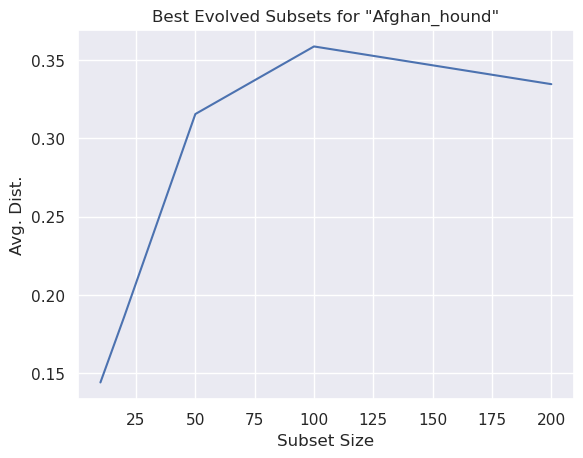

100%|██████████| 3000/3000 [00:54<00:00, 55.55it/s]


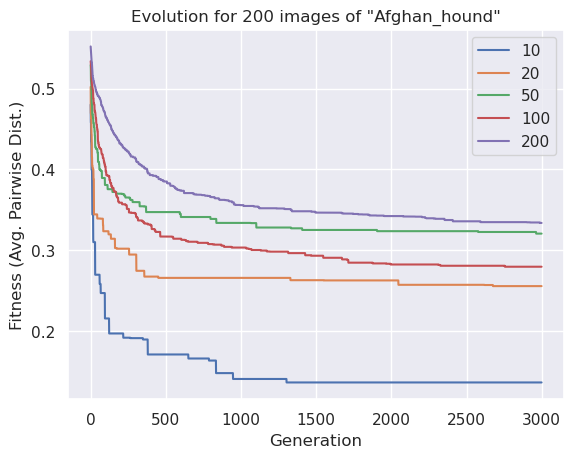

In [40]:
# Plot a single class.
clsname = "Afghan_hound"
oneclass = df.loc[df["Label"] == clsname]
ax = sns.lineplot(data=oneclass, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)
_ = ax.set_title(f'Best Evolved Subsets for "{clsname}"')
plt.show()
clsfile = cls2file[label2cls[clsname]]
res = compute_evolved_subsets_for_class(clsfile, plot=True)

# Visualization of Evolved Subset

100%|██████████| 3000/3000 [00:04<00:00, 677.91it/s]


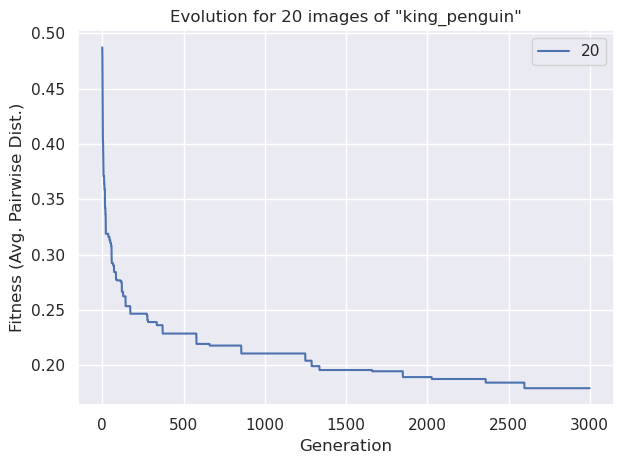

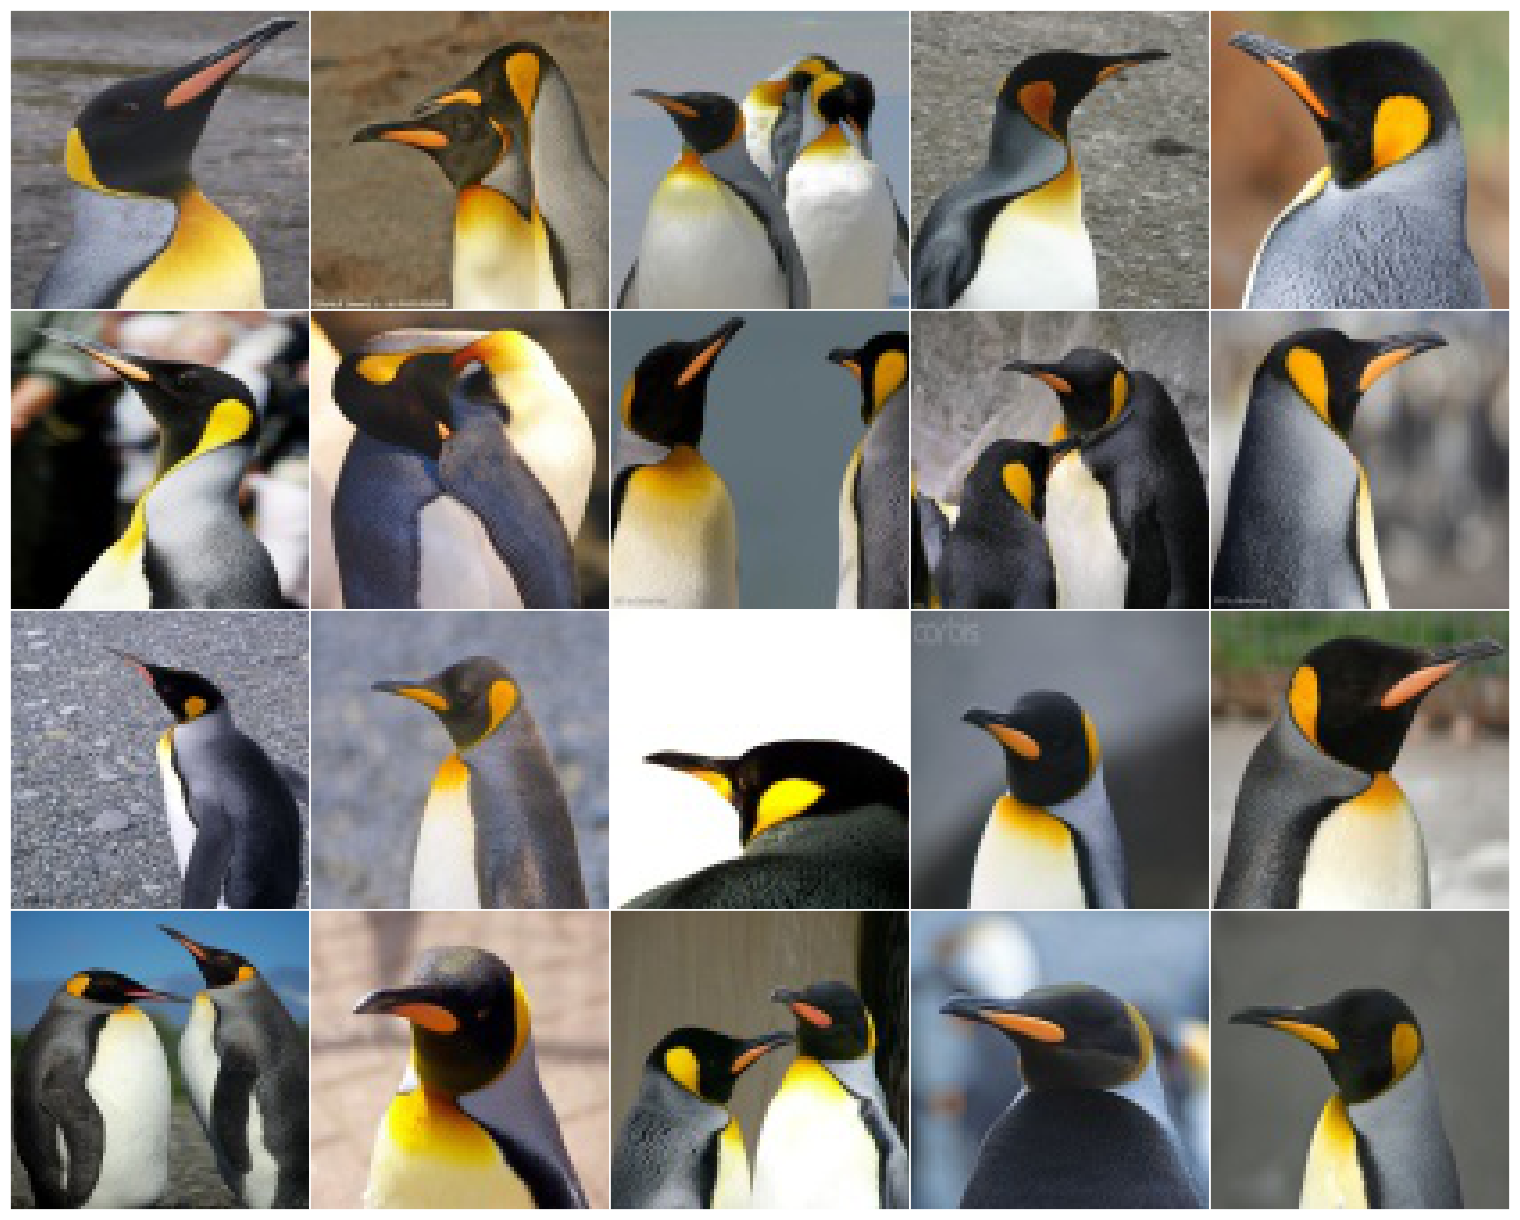

In [286]:
num_samples = 20
clsname = "king_penguin"#np.random.choice(list(label2cls.keys()))
clsid = label2cls[clsname]
clsfile = cls2file[clsid]
res = compute_evolved_subsets_for_class(clsfile, [num_samples], plot=True, its=3000)
plt.show()

view_images(clsid, res[0]["best"], pack=True)

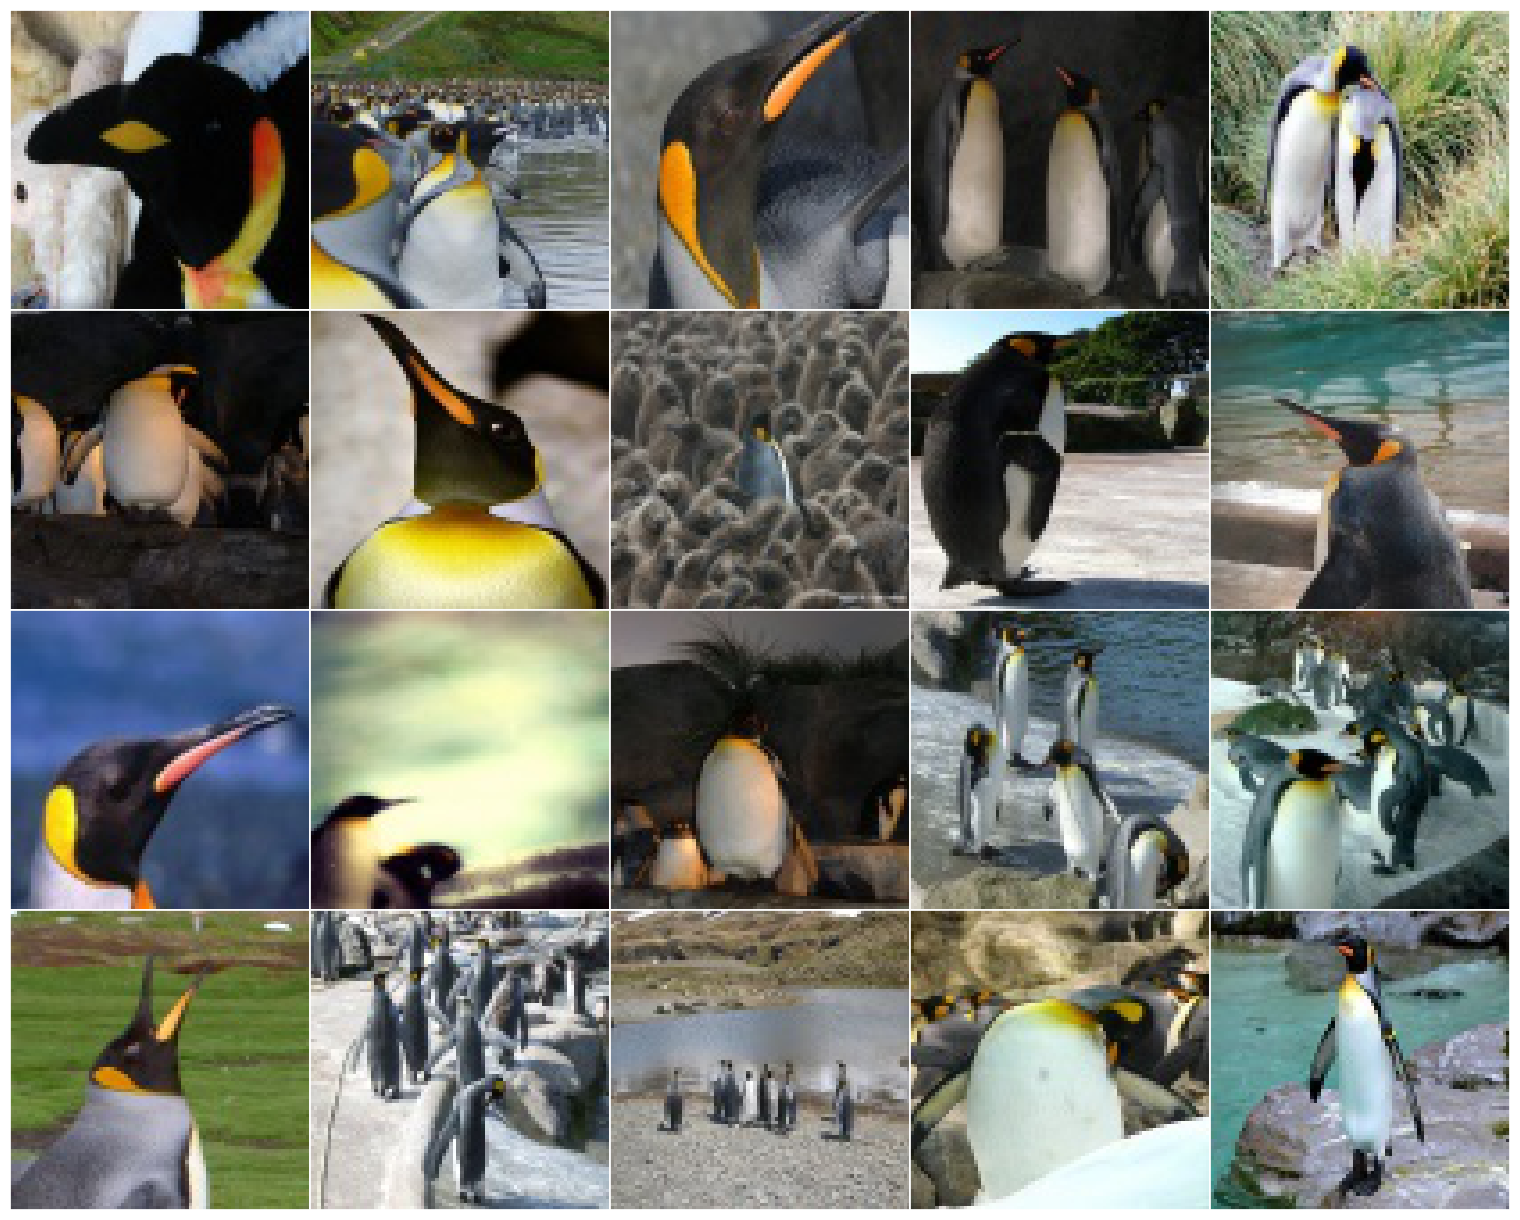

In [287]:
# Random set from the same class.
img_paths = get_image_paths(clsid)
view_images(clsid, np.random.choice(np.arange(len(img_paths)), num_samples), img_paths, pack=True)

# t-SNE Visualization

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [456]:

def plot_points(X, y, clsname=None, **kwargs):
    df = pd.DataFrame({'Component 1': X[:,0], 'Component 2': X[:,1], 'Label': y})
    if kwargs is None:
        kwargs = {}
    # `s` is marker size.
    kwargs.update({"s": 30})
    
    with sns.axes_style(style="white"):
        fig, ax = plt.subplots(1, figsize=(9, 6))
        fig.set_tight_layout(True)
        sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Label', ax=ax, **kwargs)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        sns.despine(ax=ax, left=True, bottom=True)
        if clsname:
            ax.set_title(f'Image Features for "{clsname}"')
        return ax


def compute_tSNE(X, pca_size=50, verbose=False, pca_kw=None, **kwargs):
    if pca_kw is None:
        pca_kw = {}
    if verbose:
        print(f"Matrix is all finite: {np.all(np.isfinite(X))}.")
    print(f"Running PCA on matrix with shape = {X.shape}...")
    # rmatrix = np.random.randn(X.shape[1], 2)
    # Xlow = X @ rmatrix
    pca = PCA(n_components=pca_size, **pca_kw)
    pca_result = pca.fit(X)
    Xmed = pca.transform(X)
    if verbose:
        print(f"Explained variance ratio: {pca_result.explained_variance_ratio_}")
        print(f"Singular values: {pca_result.singular_values_}")
    print(f"Running t-SNE on matrix with shape = {Xmed.shape}...")
    tsne = TSNE(n_components=2, verbose=int(verbose), **kwargs)
    Xlow = tsne.fit_transform(Xmed)
    if verbose:
        print(f"Final KL Divergence: {tsne.kl_divergence_}")
    return tsne, Xlow


def show_tSNE(X, y, clsname=None, pca_size=50, verbose=False, pca_kw=None, plot_kw=None, **kwargs):
    tsne, Xlow = compute_tSNE(X, pca_size, verbose, pca_kw, **kwargs)
    plot_points(Xlow, y, clsname, **plot_kw)
    return tsne


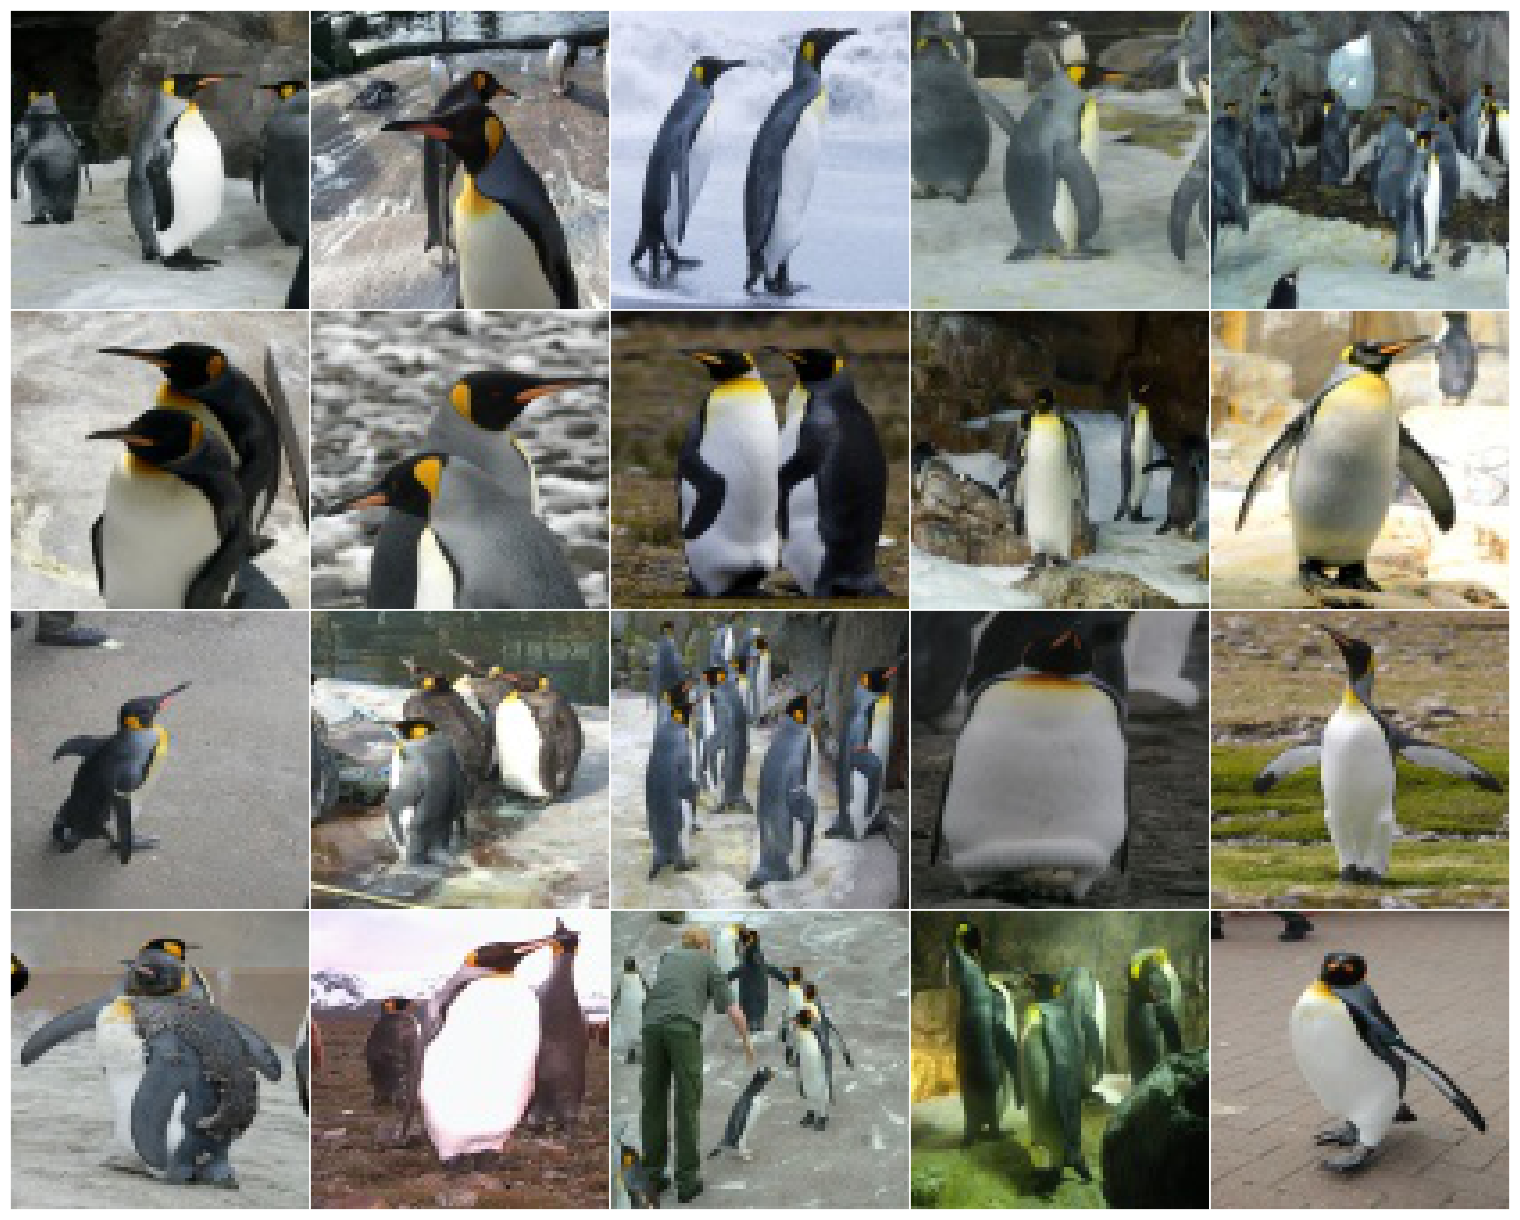

In [288]:
X = np.load(clsfile)
centroid = X.mean(axis=0)
l1_to_centroid = np.abs(X - centroid).sum(axis=1)
closest_to_centroid = np.argsort(l1_to_centroid)[:num_samples]
view_images(clsid, closest_to_centroid, img_paths, pack=True)

Matrix is all finite: True.
Running PCA on matrix with shape = (1300, 4096)...
Explained variance ratio: [0.26758575 0.13184659 0.04315865 0.03075363 0.03012647 0.02848626
 0.02404144 0.02136149 0.02028902 0.018924   0.01856668 0.01753511
 0.01565747 0.0147618  0.01374247 0.01313192 0.01305922 0.01132301
 0.0109106  0.01075674 0.01010322 0.00901535 0.00846528 0.00794426
 0.00754301 0.00719789 0.00707346 0.00645358 0.00615331 0.00587516
 0.0057412  0.00552342 0.00538041 0.00518153 0.00480126 0.00468565
 0.00454764 0.00438265 0.00409369 0.00403363 0.00386065 0.0037423
 0.00352876 0.00343597 0.00340343 0.0031424  0.00311882 0.00306649
 0.00296956 0.00294695 0.00276274 0.00262102 0.00253053 0.00248782
 0.00241174 0.00229843 0.00220358 0.00215049 0.002132   0.0020135
 0.00196257 0.00190304 0.0018162  0.00181109 0.0016693  0.00166427
 0.00160267 0.00149097 0.00146507 0.00142787 0.00134886 0.00133265
 0.00130999 0.00123633 0.00120041 0.00114089 0.00112446 0.00108238
 0.00106797 0.00103415 0.0

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.561104
[t-SNE] KL divergence after 3000 iterations: 1.625385
Final KL Divergence: 1.6253851652145386
CPU times: user 1min 4s, sys: 626 ms, total: 1min 5s
Wall time: 8.42 s


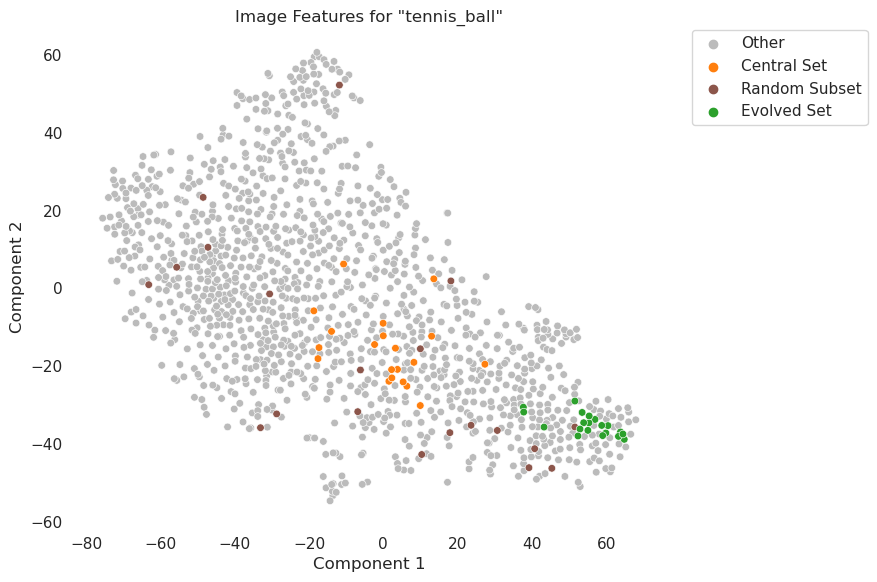

In [749]:
%%time
tsne, Xlow = compute_tSNE(X, perplexity=35,
                          n_iter=3000,
                          init="pca",
                          learning_rate=50,
                          early_exaggeration=12,
                          pca_size=100,
                          verbose=True)

y = np.full(Xlow.shape[0], "Other", dtype=object)
y[np.random.choice(y.shape[0], num_samples)] = "Random Subset"
y[closest_to_centroid] = "Central Set"
y[res[0]["best"]] = "Evolved Set"

ev_ind = (y == "Evolved Set")
central_ind = (y == "Central Set")
random_ind = (y == "Random Subset")
other_ind = (y == "Other")
X_reordered = np.concatenate((Xlow[other_ind], Xlow[central_ind], Xlow[random_ind], Xlow[ev_ind]))
y_reordered = np.concatenate((y[other_ind], y[central_ind], y[random_ind], y[ev_ind]))

ax = plot_points(X_reordered, y_reordered, clsname, palette=["#bbb", "tab:orange", "tab:brown", "tab:green"])
plt.savefig(f"{clsname}-embedding.pdf")

## Finding Visually Striking Classes

100%|██████████| 3000/3000 [00:04<00:00, 691.61it/s]


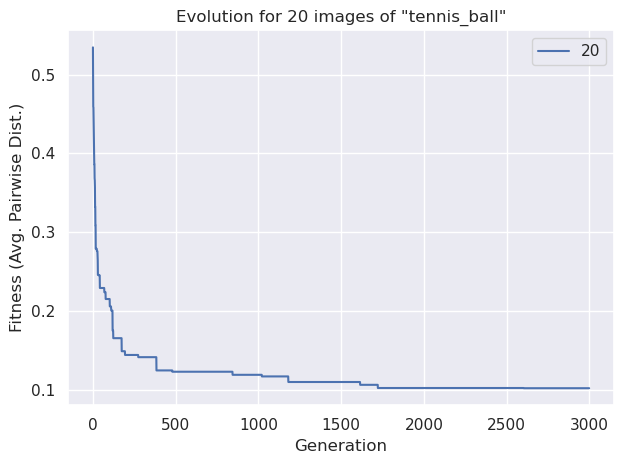

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


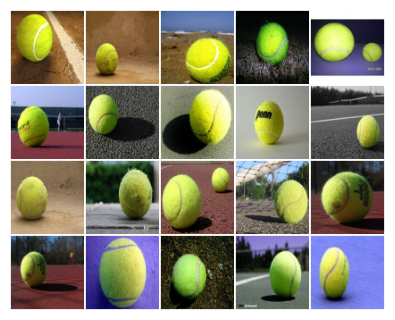

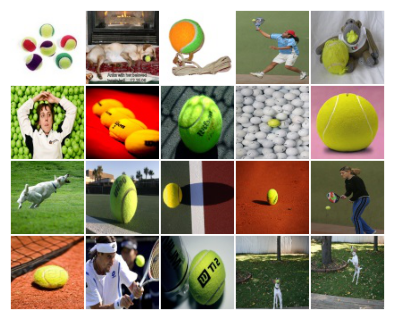

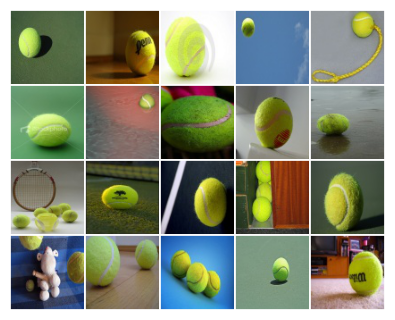

In [748]:
num_samples = 20
clsname = "tennis_ball"#np.random.choice(list(label2cls.keys()))
clsid = label2cls[clsname]
clsfile = cls2file[clsid]
res = compute_evolved_subsets_for_class(clsfile, [num_samples], plot=True, P=200, its=3000)
plt.show()

sz = 0.75
view_images(clsid, res[0]["best"], pack=True, size_multiple=sz)

img_paths = get_image_paths(clsid)
view_images(clsid, np.random.choice(np.arange(len(img_paths)), num_samples), img_paths, pack=True, size_multiple=sz)

X = np.load(clsfile)
centroid = X.mean(axis=0)
l1_to_centroid = np.abs(X - centroid).sum(axis=1)
closest_to_centroid = np.argsort(l1_to_centroid)[:num_samples]
view_images(clsid, closest_to_centroid, img_paths, pack=True, size_multiple=sz)

In [750]:
import pickle
# good_classes.append(clsname)
# maybe_classes.append(clsname)
good_results.append((clsname, res))
# good_results[-1] = (clsname, res)
with open("saved-evo-results.pkl", "wb") as f:
    pickle.dump(good_results, f)
[r[0] for r in good_results]

['joystick',
 'volcano',
 'bubble',
 'lion',
 'chain',
 'binoculars',
 'lighter',
 'matchstick',
 'black_stork',
 'Granny_Smith',
 'great_grey_owl',
 'cock',
 'barn_spider',
 'butternut_squash',
 'candle',
 'balloon',
 'umbrella',
 'water_tower',
 'puck',
 'white_wolf',
 'bloodhound',
 'king_penguin',
 'airship',
 'ox',
 'digital_clock',
 'wall_clock',
 'stopwatch',
 'mailbox',
 'skunk',
 'tennis_ball']

/tmp/ipykernel_44018/843176972.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{clsname}-evolved-set.pdf")


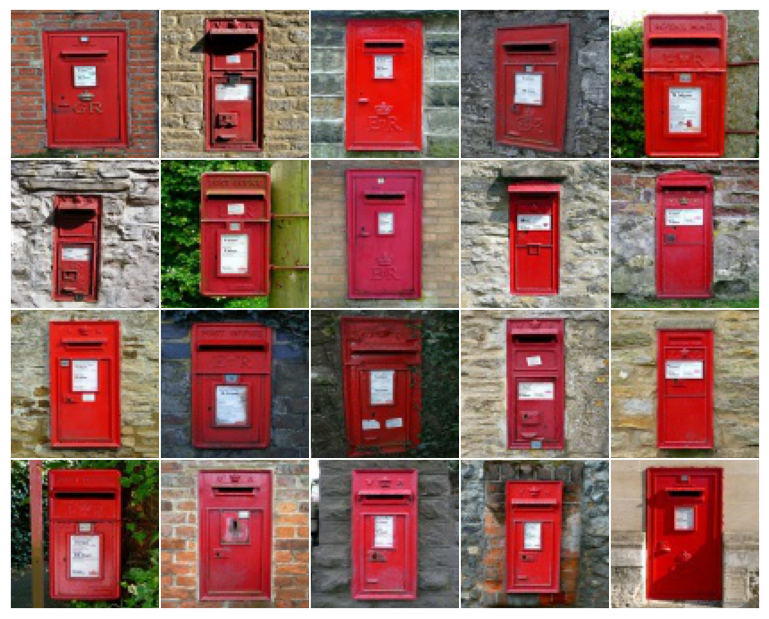

In [718]:
sz = 1.5
view_images(clsid, res[0]["best"], pack=True, size_multiple=sz)
plt.savefig(f"{clsname}-evolved-set.pdf")

Constructing images for Granny_Smith...
Constructing images for digital_clock...
Constructing images for lion...
Constructing images for umbrella...
Constructing images for white_wolf...
Making final grid...
Plotting...


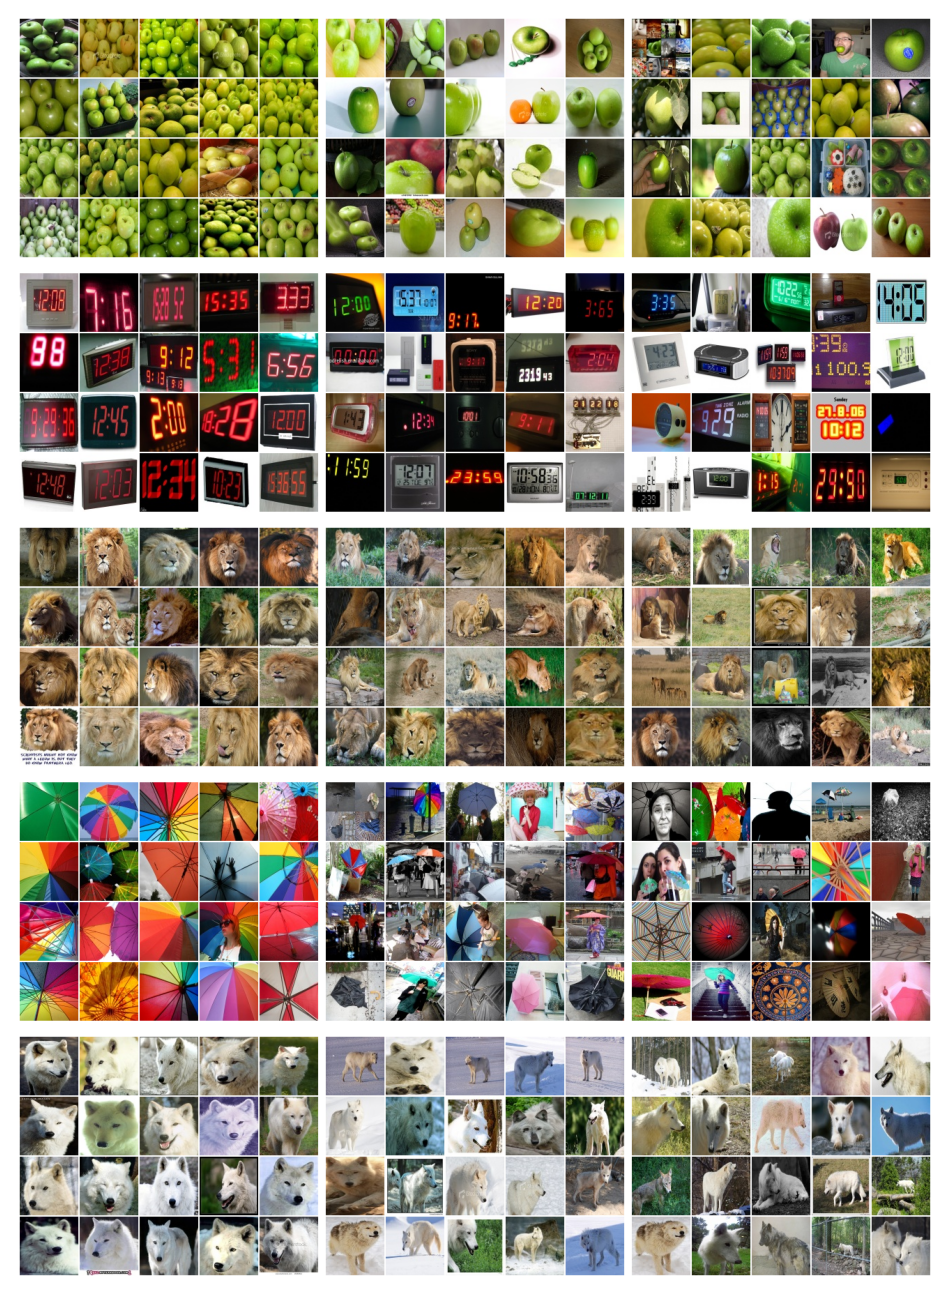

In [760]:
import torchvision.io as tvio
import torchvision.utils as tvu

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def make_image_grid(img_paths, img_indices):
    selected_paths = [img_paths[i] for i in img_indices]
    selected_images = [tvio.read_image(str(p.resolve())) for p in selected_paths]
    nrows = int(np.sqrt(len(selected_paths)))
    ncols = int(np.ceil(len(selected_paths) / nrows))
    return tvu.make_grid(selected_images, ncols, pad_value=255)


# picked_classes = [
#     "cock",
#     "joystick",
#     "bubble",
#     "matchstick",
#     "tennis_ball",
# ]
picked_classes = [
    "umbrella",
    #"airship",
    #"balloon",
    #"barn_spider",
    #"great_grey_owl",
    "digital_clock",
    "lion",
    "Granny_Smith",
    "white_wolf",
]
picked_results = sorted([r for r in good_results if r[0] in picked_classes])

class_images = []
for clsname, res in picked_results:
    print(f"Constructing images for {clsname}...")
    clsid = label2cls[clsname]
    clsfile = cls2file[clsid]
    img_paths = get_image_paths(clsid)
    evolved_indices = res[0]["best"]
    num_samples = len(evolved_indices)

    evolved_set = make_image_grid(img_paths, evolved_indices)

    X = np.load(clsfile)
    centroid = X.mean(axis=0)
    l1_to_centroid = np.abs(X - centroid).sum(axis=1)
    closest_to_centroid = np.argsort(l1_to_centroid)[:num_samples]
    central_set = make_image_grid(img_paths, closest_to_centroid)

    random_set = make_image_grid(img_paths, np.random.choice(np.arange(len(img_paths)), num_samples))
    
    class_grid = tvu.make_grid([evolved_set, central_set, random_set], 3, padding=7, pad_value=255)
    class_images.append(class_grid)

print("Making final grid...")
big_image = tvu.make_grid(class_images, 1, padding=5, pad_value=255)

print("Plotting...")
show(big_image)

plt.savefig("image-samples-2.pdf")

## Skunk Plot

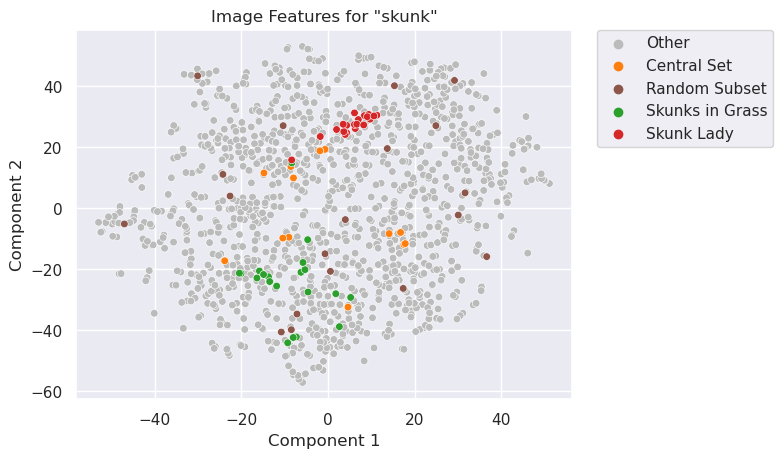

In [166]:
y = np.full(Xlow.shape[0], "Other", dtype=object)
y[np.random.choice(y.shape[0], num_samples)] = "Random Subset"
y[closest_to_centroid] = "Central Set"
y[skunk_grass[0]["best"]] = "Skunks in Grass"
y[skunk_lady2[0]["best"]] = "Skunk Lady"

sg_ind = skunk_grass[0]["best"]
sl_ind = skunk_lady2[0]["best"]
central_ind = (y == "Central Set")
random_ind = (y == "Random Subset")
other_ind = (y == "Other")
X_reordered = np.concatenate((Xlow[other_ind], Xlow[central_ind], Xlow[random_ind], Xlow[sg_ind], Xlow[sl_ind]))
y_reordered = np.concatenate((y[other_ind], y[central_ind], y[random_ind], y[sg_ind], y[sl_ind]))

ax = plot_points(X_reordered, y_reordered, clsname, palette=["#bbb", "tab:orange", "tab:brown", "tab:green", "tab:red"])
plt.savefig("skunk-embedding.pdf")

In [121]:
res